# Main Script



#### Needed Imports

In [ ]:
#Installo le librerie
%pip install -U seaborn
%pip install --upgrade keras
#%pip install --upgrade tensorflow
%pip install --upgrade tensorboard
#%pip install torch torchvision torchaudio #Only CPU
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #CUDA 11.8
%pip install --upgrade Pillow

# %pip install --upgrade pip setuptools wheel #Aggiorna i pacchetti e Python, ma ci mette troppo.

In [1]:
#Import delle Librerie
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import iqr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
# import tensorflow as tf
# from tensorflow import keras
# from keras.layers import Dense
# from keras.models import Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split
import pickle
import random
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Loading data from data_loader.py

In [2]:
# CSV zip folder's path
csv_file_name = '../data.zip'

# loading data from csv
data = pd.read_csv(csv_file_name)

In [ ]:
# CSV zip folder's path
csv_file_name = '/content/drive/MyDrive/Colab Notebooks/data.zip'

# loading data from csv
data = pd.read_csv(csv_file_name)

In [ ]:
len(data)

---
#### Data Acquisition

#### Describing data

In [3]:
#print shape of dataset
print("Dataset shape:",data.shape) #25175 row, 91 columns. We know that the label Y ('year) is the first one column.

# saving data without first column 'year'
no_target_column_data = data[data.columns[1:]]
print(no_target_column_data.describe())

Dataset shape: (252175, 91)
                  S0             S1             S2             S3   
count  252175.000000  252175.000000  252175.000000  252175.000000  \
mean       43.379379       1.555258       8.643927       1.160078   
std         6.066547      51.551085      35.235495      16.336577   
min         3.455260    -334.953220    -301.005060    -149.962040   
25%        39.959775     -25.651750     -11.524900      -8.492585   
50%        44.250440       8.655610      10.516440      -0.641920   
75%        47.822515      36.248650      29.792790       8.766685   
max        61.970140     384.065730     318.868960     228.412110   

                  S4             S5             S6             S7   
count  252175.000000  252175.000000  252175.000000  252175.000000  \
mean       -6.526075      -9.532049      -2.366866      -1.788645   
std        22.841967      12.809154      14.530697       7.963275   
min      -181.953370     -72.717370    -111.017810     -68.404510   
25%  

In [ ]:
#Descrizione database
data.info() #Non ci sono valori mancanti e tutte le colonne dello stesso tipo (float64) ad eccezione della colonna 'Year' (int64)

In [11]:
target_label = data[data.columns[:1]]

#### Data by target column 'Year'

Sono presenti righe con categorie della colonna target 'Year' che vanno dal 1956 al 2009.

C'è uno sbilanciamento del dataset, che presenta molte più righe (e per cui canzoni e features su cui verranno allenati i modelli) per gli anni dal (circa) 1990 in poi.

Infatti, nel dataset per il 1990 stesso ci sono 3628 righe, per il 2000 ce ne sono più di 9mila e per il 2009 (anno maggiore == più vicino nel tempo all'anno odierno) ce ne sono più di 15mila.
In generale per gli anni 2000 ci sono circa più di 10mila righe, per gli altri, allontanandosi sempre più indietro nel tempo, ce ne sono sempre meno fino a toccare un minimodi circa 200 / 300.

E' necessario bilanciare il dataset o comunque affidare dei pesi ad ogni categoria / classe in modo tale che il training sia bilanciato in base ai dati a nostra disposizione.

In [ ]:
sorted_data_by_year = data.sort_values(by='Year')

year_count = sorted_data_by_year['Year'].value_counts()
print(year_count.sort_index())

In [ ]:
infos=sorted_data_by_year.groupby('Year')
print(infos.describe())

---
#### Data visualization

##### Density plot

In [ ]:
#Funzione Density Plot/Histogramma per tutte le colonne del dataset

def plot_density(dataset, columns_per_row=4, figsize=(15, 10)):
   
    num_columns =data.shape[1]
    num_rows = (num_columns - 1) // columns_per_row + 1
    
    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=figsize)
    axes = axes.flatten()
    
    for i, column in enumerate(dataset.columns):
        ax = axes[i]
        ax.set_title(column)
        ax.hist(dataset[column], density=True, bins=30, alpha=0.5)
        dataset[column].plot(kind='kde', ax=ax, color='blue')
        
    for ax in axes[num_columns:]:
        ax.axis('off')  # Nasconde gli assi per le eventuali celle vuote
        
    plt.tight_layout()
    plt.show()

# Utilizzo della funzione 
plot_density(data.iloc[:,1:], columns_per_row=4, figsize=(55, 50))


Dal density plot notiamo come non sia presente una distribuzione gaussiana dei dati.

##### Box plot

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=no_target_column_data, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S0 to S12
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,0:13], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S13 to S23
plt.figure(figsize=(10, 15))
sns.boxplot(data=no_target_column_data.iloc[:,13:24], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S24 to S34
plt.figure(figsize=(10, 17))
sns.boxplot(data=no_target_column_data.iloc[:,24:35], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S35 to S45
plt.figure(figsize=(10, 17))
sns.boxplot(data=no_target_column_data.iloc[:,35:46], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S46 to S54
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,46:55], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S55 to S64
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,55:65], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S65 to S75
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,65:76], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S76 to S82
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,76:83], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

In [ ]:
# Box plot S83 to S89
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,83:90], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

Nei **Boxplots** che abbiamo mostrato qua sopra, si possono notare come le features hanno una distribuzione di dati simile per quasi tutte le colonne, tranne per quelle che vanno da: *S0* a *S12*. Sono presenti, per ogni features, un gran numero di *outliers* sia sotto i valori minimi sia sopra i valori massimi del boxplot.



##### Correlation Matrix

In [ ]:
# Calcolare la matrice di correlazione
correlation_matrix = no_target_column_data.corr()

# Creare una heatmap della matrice di correlazione usando seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

In [ ]:
# Eliminare i coefficienti di correlazione uguali a 1
correlation_matrix = correlation_matrix.mask(correlation_matrix == 1)

# Estrarre le prime 20 coppie con i coefficienti di correlazione più alti
top_corr_pairs = correlation_matrix.unstack().nlargest(40)

# Stampa i nomi delle colonne delle prime 20 coppie
print("Nomi delle colonne delle prime 20 coppie con coefficiente di correlazione più alto:")
for (var1, var2), corr in top_corr_pairs.items():
    print(f"{var1} e {var2}, Correlazione: {corr}")
    print(f"Nomi delle colonne: {var1}, {var2}")
    print()

##### Correlation matrix su tutto il dataset
Data la correlation matrix riportata sopra abbiamo notato come vi sia una forte relazione tra le colonne da S12 a S24 circa, che sono caratterizzate da una forte presenza di valori outlier (lo abbiamo visto dai boxplot).
Dunque, proviamo anche a calcolare la correlation matrix escludendo queste colonne.

In [ ]:
subset_data = pd.concat([no_target_column_data.iloc[:,:12], no_target_column_data.iloc[:,24:]], axis=1)

# Calcolare la matrice di correlazione
correlation_matrix = subset_data.corr()

# Creare una heatmap della matrice di correlazione usando seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

In [ ]:
# Eliminare i coefficienti di correlazione uguali a 1
correlation_matrix = correlation_matrix.mask(correlation_matrix == 1)

# Estrarre le prime 20 coppie con i coefficienti di correlazione più alti
top_corr_pairs = correlation_matrix.unstack().nlargest(40)

# Stampa i nomi delle colonne delle prime 20 coppie
print("Nomi delle colonne delle prime 20 coppie con coefficiente di correlazione più alto:")
for (var1, var2), corr in top_corr_pairs.items():
    print(f"{var1} e {var2}, Correlazione: {corr}")
    print(f"Nomi delle colonne: {var1}, {var2}")
    print()

##### Correlation matrix (S12:S24 escluse)
In questa correlation matrix notiamo come i coefficienti di correlazione siano effettivamente più bassi, evidenziando il fatto che le variabili non sono correlate nello stesso modo in cui lo sono quelle dalla 12 alla 24.

Dobbiamo dunque trattare gli outlier prima di poter stabilire quali variabili siano più rilevanti rispetto alle altre.

##### Conclusioni dopo data visualization
Dal processo di visualizzazione dei dati deduciamo che è necessario trattare gli *outliers*: consideriamo quindi che non siano rilevanti per l'allenamento del nostro modello, ma si tratti di dati rumorosi e fuorvianti.

In ogni caso valutare allenamento modelli con outliers.

Valutare problema di **High Dimensionality**: tramite PCA (Princial Component Analysis) e LDA (Linear Discrimination Analysis)

Valutare **Normalizzazione**: vedendo la distribuzione non gaussiana, opterei per **MinMaxScaling** (non escludere *Standardization*)

##### Trattamento outliers by winsorization

In [ ]:
no_target_column_smoothed_data = pd.DataFrame(no_target_column_data.copy())

def winsorize_column(column, k=1.5):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    column = np.where(column < lower_bound, lower_bound, column)
    column = np.where(column > upper_bound, upper_bound, column)
    return column

for column in no_target_column_smoothed_data.columns:
  no_target_column_smoothed_data[column] = winsorize_column(no_target_column_smoothed_data[column])

#### Z-SCORE (sostituzione outliers con MEDIAN) : MSE (post MinMaxScaling) : 41.132

In [ ]:
def replace_outliers_with_median(dataset, threshold=3):
    # Copia del dataset per evitare modifiche indesiderate
    cleaned_dataset = dataset.copy()

    # Itera su ogni colonna/feature del dataset
    for column in cleaned_dataset.columns:
        # Calcola lo z-score per la feature corrente
        z_scores = np.abs(stats.zscore(cleaned_dataset[column]))

        # Trova gli outliers superando la soglia
        outliers_indices = np.where(z_scores > threshold)[0]

        # Sostituisci gli outliers con la mediana della colonna
        column_median = cleaned_dataset[column].median()
        cleaned_dataset[column].iloc[outliers_indices] = column_median

    return cleaned_dataset

In [ ]:
# Sostituisci gli outliers con la media delle colonne
data_rmoutliers = replace_outliers_with_mean(data, 2)

In [ ]:
data_rmoutliers.shape

In [ ]:
data_rmoutliers.isna().sum().sum() #Restituisce il Num totale dei valori NaN

In [ ]:
X = no_target_column_smoothed_data[no_target_column_smoothed_data.columns[1:]]
y = no_target_column_smoothed_data[no_target_column_smoothed_data.columns[:1]]

#### Preprocessing: suddivisione del dataset

In [13]:
X=no_target_column_data.copy() #90 COLONNE
y=target_label.copy()

#### Splitting Dataset: Train & Validation

In [14]:
# X sono le feature (variabili indipendenti), y è la colonna target
# 80% training set - 20% validation set
seed=89
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed,stratify=y)

In [ ]:
import numpy as np

def find_nan_positions(data):
    nan_positions = np.argwhere(pd.isna(data).to_numpy())
    return nan_positions

nan_positions = find_nan_positions(X_train)

if nan_positions.size > 0:
    print("Valori NaN trovati alle seguenti posizioni:")
    for position in nan_positions:
        print(f"Riga: {position[0] + 1}, Colonna: {position[1] + 1}")
else:
    print("Il DataFrame non contiene valori NaN.")


---
#### Data Preprocessing (LR)


In [15]:
X = X_train.copy()
y = y_val.copy()

##### Boxplot after outliers' smoothing

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=X, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

#### Undersampling e Oversampling (non migliora MSE) 

In [ ]:
from collections import Counter
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

def downSampling(x_train,y_train):
    # Controlla la distribuzione delle classi prima del downsampling
    print("Distribuzione delle classi prima del downsampling:")
    print(Counter(y_train['Year']))

    cc = ClusterCentroids(random_state=seed,)

    # Effettua il downsampling
    X_resampled, y_resampled = cc.fit_resample(X, y_train['Year'])

    return X_resampled,y_resampled

def upSampling(x_train,y_train):
    X_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train['Year'])
    return X_resampled,y_resampled


x_resempled,y_resampled= upSampling(X_train,y_train)


##### Min max scaling

In [26]:
X_Validation = X_val.copy()

# Min-Max Scaling
# Creazione dell'oggetto MinMaxScaler e adattamento solo al training set
#file = open("scaler.save","wb") #salvataggio dello scaler sul disco nel file "scaler.save"
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#apply transform on validation set
X_val_scaled = scaler.transform(X_Validation)
#pickle.dump(scaler, file)
#file.close()

#name columns after min-max scaling
# num_colonne = X_scaled.shape[1]  # Ottieni il numero di colonne
# nome_colonne = ['S' + str(i) for i in range(num_colonne)]
# X_scaled_df = pd.DataFrame(X_scaled, columns=nome_colonne)

# print("Dati di training originali:")
# print(X)
print("\nDati di training normalizzati MinMaxScaling:")
print(X_scaled)
# print("\nDati di validation originali:")
# print(X_Validation)
# print("\nDati di validation normalizzati Min-Max:")
# print(X_val_scaled)


Dati di training normalizzati MinMaxScaling:
[[0.60871594 0.53356923 0.4494677  ... 0.53845299 0.51108995 0.35777756]
 [0.56156007 0.50000065 0.67651561 ... 0.47862945 0.52086774 0.37412128]
 [0.7086659  0.56483163 0.51686467 ... 0.49568095 0.50430072 0.33343394]
 ...
 [0.62054814 0.41932825 0.42143407 ... 0.50094978 0.51898317 0.34341102]
 [0.76981599 0.53818665 0.51157919 ... 0.49243993 0.50699643 0.31996933]
 [0.54791055 0.34766547 0.56625569 ... 0.54115006 0.50531332 0.40491751]]


#### Standardization

In [ ]:
# standardization of dependent variables
scaler=StandardScaler()
#standardization x_train
X_std = scaler.fit_transform(X) 
#apply transform on validation set
X_val_std = scaler.transform(X_Validation)

##### Boxplot after min max scaling

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=X_scaled, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

##### Density plot after min max scaling

In [ ]:
# Density plot
fig, axs = plt.subplots(15, 3, figsize=(15, 60))
counter = 0

for i in range(15):
  for j in range(3):

    # Plot KDE
    sns.kdeplot(X_scaled[:,counter], ax=axs[i, j], color='g', bw_adjust=2, label='Smooth factor=2')

    # Plot CDF
    sns.kdeplot(X_scaled[:,counter], ax=axs[i, j], color='r', cumulative=True, label='CDF')

    axs[i, j].set_xlabel("S" + str(counter))
    counter = counter+1

plt.show()

##### PCA

##### Studio n_components

In [ ]:
num_columns = X_scaled.shape[1]
nums = np.arange(num_columns)

In [ ]:
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_scaled)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

In [ ]:
#Dalla Figura si nota come la linea di cutoff del 95% interseca il valore della X nella colonna 51/52
plt.figure(figsize=(30,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.xticks(np.arange(0,90,1))
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
#linea di cutoff del 95%
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

##### PCA Analysis

In [41]:
# Inizializzare l'oggetto PCA
pca = PCA(n_components=60) #52
X_decomposed = pca.fit_transform(X_scaled)
#pca.get_feature_names_out(X_scaled_df.columns)

# Ottieni i vettori delle componenti principali
components = pca.components_

#validation data after PCA
X_val_decomposed = pca.transform(X_val_scaled)

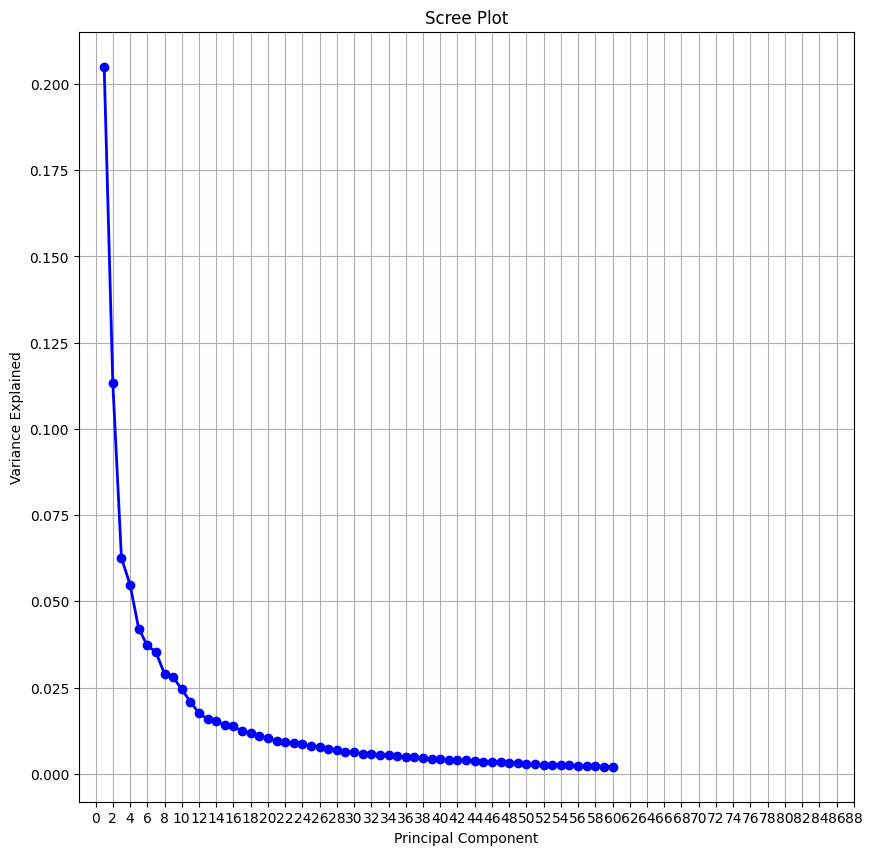

Explainer variance of each component: [0.20499425 0.11326805 0.06260329 0.05487393 0.04212703 0.03721034
 0.03531028 0.02898064 0.02808624 0.02447684 0.02093433 0.01754915
 0.01584797 0.01530311 0.01411703 0.01393756 0.01228069 0.01174361
 0.01085562 0.01048741 0.00944707 0.00934988 0.00884554 0.00858169
 0.00808362 0.00792102 0.00733786 0.00684275 0.00636793 0.00625115
 0.00572563 0.00560582 0.00557712 0.00534292 0.00515724 0.0049721
 0.00479294 0.00470561 0.00433031 0.00425375 0.00399548 0.00392499
 0.00386812 0.00372575 0.00355459 0.00346475 0.00340964 0.00324852
 0.00314448 0.00281733 0.00276975 0.00266551 0.00264494 0.00254252
 0.00243548 0.00231898 0.00223619 0.00215607 0.00208991 0.00206051]
Variance total: 0.9635528232139299


In [42]:
#Scree Plot -> mostra la percentuale di variazione spiegata da ogni componente principale
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.xticks(range(0,90,2))
plt.ylabel('Variance Explained')
plt.show()
print("Explainer variance of each component:",pca.explained_variance_ratio_)
print("Variance total:", sum(pca.explained_variance_ratio_))

In [ ]:
num_columns=X_decomposed.shape[1]

##### Boxplot after PCA

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=X_decomposed, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

#### Regressione Lineare

In [45]:
##MinMaxScaling(), MSE: 84.500
##MinMaxScaling(),PCA, MSE:86.114

regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_scaled, y_train)

#file = open("Lregression.save","wb")
#pickle.dump(regr, file)
#file.close()

# Make predictions using the testing set
y_predictions = regr.predict(X_val_scaled)
#MSE
mse = mean_squared_error(y_val, y_predictions)
#MAE
mae = mean_absolute_error(y_val, y_predictions)
#MAPE
mape = mean_absolute_percentage_error(y_val, y_predictions)
#R2
r2 = r2_score(y_val, y_predictions)

print("Mean squared error: %.3f" % mse)
print("MAE: %.3f" % mae)
print("MAPE: %.3f" % mape)
print("R2: %.3f" % r2)

Mean squared error: 84.343
MAE: 6.603
MAPE: 0.003
R2: 0.235


#### Random Forest Regressor con GridSearch

In [46]:


# Definire la grid e la metrica di valutazione
grid1 = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [1,2, 3],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Creare la scorning function
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv=5, 
                      scoring="neg_mean_squared_error",n_jobs=-1,verbose=2)

# Modificare la forma del target y
y_train_reshaped = np.ravel(y_train)

CV_rfr.fit(X_scaled, y_train_reshaped)

predictions = CV_rfr.predict(X_val_scaled)
mse = mean_squared_error(y_val, predictions)

# Print results
print("----------BEST PARAMS----------")
print(CV_rfr.best_params_)
print("--------------------------------")
print("Mean squared error: %.3f" % mse)

#-------------MINMAXSCALING (CON PCA=80)------------------
#----------BEST PARAMS----------
#{'max_depth': 4, 'n_estimators': 300, 'random_state': 89}
#Mean squared error: 93.907
#-------------MINMAXSCALING (CON PCA=52)------------------
# ----------BEST PARAMS----------
# {'max_depth': 4, 'n_estimators': 1000, 'random_state': 89}
# --------------------------------
# Mean squared error: 93.910

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [ ]:
# Inizializza il regressore Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42,)
new_y = np.ravel(y)
# Calcola l'MSE utilizzando la cross-validation
# cv da modificare --> provare valori più bassi principalmente perchè dataset molto grande
mse_scores = cross_val_score(rf_regressor, X_scaled, y_val, cv=5, scoring='neg_mean_squared_error')

# Calcola l'MSE medio
mse_mean = -mse_scores.mean()

print("Mean Squared Error (MSE):", mse_mean)

#### KNN con GridSearch (Provare con Dati Normalizzati, Rimuovendo Outliers e PCA)

In [32]:
# Definisci i parametri da testare
# param_grid = {'n_neighbors': [3, 5, 7, 9, 11]} vecchia iterazione
param_grid = {'n_neighbors': list(range(25, 60)), "weights": ["uniform","distance"],"n_jobs":[-1]} #-1 means using all processors.

# Crea un'istanza del modello KNN per la regressione
knn_regressor = KNeighborsRegressor()
y_train_new = np.ravel(y_train)

# Crea un'istanza di GridSearchCV per trovare il miglior parametro
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Esegui la ricerca dei parametri utilizzando il set di addestramento
grid_search.fit(X_scaled, y_train_new)

# Ottieni il miglior parametro trovato
best_k = grid_search.best_params_['n_neighbors']
best_weight = grid_search.best_params_['weights']

# Utilizza il modello addestrato con il miglior parametro per fare previsioni su nuovi dati
best_knn_regressor = grid_search.best_estimator_
y_predictions = best_knn_regressor.predict(X_val_scaled)

# scores = []
# for i in range(1,100):
#     knn = KNeighborsRegressor(n_neighbors=i)
#     knn.fit(X_scaled,y_train_new)
#     y_pred = knn.predict(X_val_scaled)
#     scores.append(accuracy_score(y_val, y_pred))

# plt.plot(range(1,16),scores)

# Calcola le metriche di valutazione
mse = mean_squared_error(y_val, y_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_predictions)
mae = mean_absolute_error(y_val, y_predictions)
#MAPE
mape = mean_absolute_percentage_error(y_val, y_predictions)

print("Miglior parametro K:", best_k, "weights:",best_weight)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)
print("MAE:", mae)
print("MAPE: %.3f" % mape)
# BEST PARAMS
# Miglior parametro K: 28 weights: distance
# MSE: 76.07494414444997

Miglior parametro K: 28 weights: distance
MSE: 76.07494414444997
RMSE: 8.722095169421735
R2 Score: 0.30976056378715866
MAE: 6.315206873574911
MAPE: 0.003


#### SVM Regressor

In [ ]:
# Definizione della griglia di iperparametri e kernel
param_grid = {
    'C': [0.1, 1, 10, 40],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

y_train_new = np.ravel(y_train)

# Creazione del modello SVR
svr_model = SVR()

# Ricerca Grid per il tuning degli iperparametri e dei kernel
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_decomposed, y_train_new)

# Valutazione del modello migliore
best_model = grid_search.best_estimator_
y_predictions = best_model.predict(X_val_decomposed)

# Calcola MSE
mse = mean_squared_error(y_val, y_predictions)
# Calcola RMSE
rmse = np.sqrt(mse)
# Calcola R2 Score
r2 = r2_score(y_val, y_predictions)
# Calcola MAE
mae = mean_absolute_error(y_val, y_predictions)
# Calcola MAPE
mape = mean_absolute_percentage_error(y_val,y_predictions)

print("Best parameters:", grid_search.best_params_)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)
print("MAE:", mae)
print("MAPE:", mape)

#### FF (Feed-Forward) reti neurali

In [ ]:
# For reproducibility

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False # settandolo a False  si assicura che venga utilizzata una configurazione fissa, migliorando la riproducibilità.
    torch.backends.cudnn.deterministic = True  # slower

In [ ]:
# Definizione del Dataset personalizzato
class MyDataset(Dataset): #Quando si instanzia la classe Dataset, viene fatto 1 sola volta
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        # Aggiungi view per reshaping, trasforma in una matrice 2D, dove -1 sta a significare che pytorch determina num righe
        #1 il num di colonne
        #quindi avremo una matrice con n righe e 1 colonna
        #si fa questo perchè per problemi di regressione è necessario usare tensori bidimensionali (ad esempio per la nn.MSEloss)
        self.y = torch.FloatTensor(y.values).view(-1, 1)  
        self.num_features = X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]
          

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FeedForward, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, 1)  # Un singolo neurone per l'output di regressione
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.fc1(x)
        h = self.relu(h)
        output = self.fc2(h)  # Nessuna attivazione per l'output layer
        return output

In [ ]:
# Define a function to evaluate the performance on validation and test sets

def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        y_pred.append(output)
        y_test.append(targets)
    
    # Converti le liste in tensori PyTorch e applica squeeze per ridurre le dimensioni aggiuntive
    y_test = torch.cat(y_test).squeeze()  # Concatena e riduci le dimensioni
    y_pred = torch.cat(y_pred).squeeze()
    
    return y_test, y_pred


In [ ]:
# Define a function for the training process

def train_model(model, criterion, optimizer, epoch, train_loader, val_loader, device, writer, log_name="model"):            #criterion = lossfunction
    n_iter = 0
    best_valid_loss = float('inf')
    for epoch in range(epoch):
        model.train()
        
        for data, targets in train_loader:                                                          #il train_loader restituisce batch
            data, targets = data.to(device), targets.to(device)  # why here?                        #sto spostando i dati del batch in gpu
            
            optimizer.zero_grad()                                                                   #azzero il gradiente

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)                                           #salvo la loss (per visualizzarla successivamente)

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1
        
        #valido
        labels, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", loss_val, epoch)
        
        # save best model
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            if not os.path.exists('models'):
                os.makedirs('models')
            torch.save(model.state_dict(), 'models/'+log_name)
            
    return model

In [ ]:
# look for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

In [ ]:
seed = 89

# Train hyperparameters
num_epochs = 100  # try 100, 200, 500
learning_rate = 0.01
batch = 32

In [ ]:
data = pd.read_csv("../data.zip")
X = data[data.columns[1:]]
y = data['Year']
indices = np.arange(X.shape[0])                         #un tip che usa è splittare gli indici corrispondenti invece dei dati veri e propri

# Separate indices
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)

# La normalizzazione dell'intero dataset X 
# usando le statistiche del set di addestramento (train_idx) 
# garantisce che non vi sia data leakage e che 
# la normalizzazione sia consistente tra il set di addestramento e quello di validazione.

# Scale data (fatto dal prof)
#train_mean = np.mean(X[train_idx,:], axis=0)
#train_std = np.std(X[train_idx,:], axis=0)
#X = (X - train_mean) / train_std

#Scale data with MinMaxScaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X.iloc[:train_idx,:]) #se non funziona prova X.iloc[train_idx,:]
X_scaled = scaler.transform(X)


# Create the dataset
my_dataset = MyDataset(X_scaled,y)


# Create subsets and relative dataloader                                            #DataLoader crea i batch
train_subset = Subset(my_dataset, train_idx)
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)                 #mette shiffle=True solo nel DataLoader del train perché è utile per la rete avere batch shufflati

val_subset = Subset(my_dataset, val_idx)
val_loader = DataLoader(val_subset, batch_size=1)

hidden_size = 32  # architecture hyperparameter
model = FeedForward(my_dataset.num_features, hidden_size, my_dataset.y)
model.to(device)

Run Tensorboard from the command line:

"tensorboard --logdir runs/"

In [ ]:
# fix the seed for reproducibility
fix_random(seed)


# Start tensorboard
writer = SummaryWriter()


# Define the architecture, loss and optimizer
hidden_size = 32  # architecture hyperparameter
model = FeedForward(my_dataset.num_features, hidden_size, my_dataset.y)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Test before the training
y_test, y_pred_c, _ = test_model(model, val_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy before training:", acc.cpu().numpy())


# Train the model 
model = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)


# Load best model
model.load_state_dict(torch.load("models/model"))
model.to(device)


# Test after the training
y_test, y_pred_c, _ = test_model(model, val_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy after training:", acc.cpu().numpy())


# Close tensorboard writer after a training
writer.flush()
writer.close()

---
#### Data Modeling (tuning hyperparams)


---
#### Performance Evaluation
